# Study the effect of the galactic plane fix in the GNILC dust models

In [1]:
import os

os.environ[
    "OMP_NUM_THREADS"
] = "64"  # for jupyter.nersc.gov otherwise the notebook only uses 2 cores

In [2]:
from pathlib import Path
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pymaster as nmt
from astropy.io import fits

%matplotlib inline

In [3]:
plt.style.use("seaborn-talk")

In [4]:
import pysm3 as pysm
import pysm3.units as u

In [5]:
nside = 2048
lmax = 2048

In [6]:
comp = "IQU"

In [7]:
components = list(enumerate(comp))
components

[(0, 'I'), (1, 'Q'), (2, 'U')]

In [8]:
spectra_components = ["TT", "EE", "BB"]

change this to True   if you want to  run namaster on notebook 


In [9]:
namaster_on_nb = True 

In [10]:
datadir=Path("data/")

## Load again the GNILC dust maps

- We use the  2015 GNILC intensity map from the 2nd planck release, as it encodes less contamination from CIB with 21.8' resolution https://www.dropbox.com/s/hicocet83z31ob3/COM_CompMap_Dust-GNILC-F353_2048_21p8acm.fits?dl=0

- for Q and U we adopt maps from the 3rd Planck release as they were optimized for polarization studies with 80' reso.  



In [11]:
dust_varresI = datadir / "COM_CompMap_Dust-GNILC-F353_2048_21p8acm.fits"
dust_varresP = datadir / "COM_CompMap_IQU-thermaldust-gnilc-varres_2048_R3.00.fits"

In [12]:
if not dust_varresI.exists():
    !wget -O $dust_varresI https://www.dropbox.com/s/hicocet83z31ob3/COM_CompMap_Dust-GNILC-F353_2048_21p8acm.fits?dl=0

In [13]:
if not dust_varresP.exists():
    !wget -O $dust_varresP http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=COM_CompMap_IQU-thermaldust-gnilc-varres_2048_R3.00.fits

Transform maps to double precision for computations

In [14]:
m_planck_varres, h = hp.read_map(dust_varresP, [c + "_STOKES" for c in comp], dtype=np.float64, h=True)
I_planck_varres, h = hp.read_map(dust_varresI, dtype=np.float64, h=True)

Maps from the two releases are in different units `MJy/sr` the former, and `K_CMB` the latter, we therefore need to perform some conversion to `uK_RJ`. 

In [15]:
m_planck_varres <<= u.K_CMB
I_planck_varres <<= u.MJy / u.sr
m_planck_varres = m_planck_varres.to(
    "uK_RJ", equivalencies=u.cmb_equivalencies(353 * u.GHz)
)
I_planck_varres = I_planck_varres.to(
    "uK_RJ", equivalencies=u.cmb_equivalencies(353 * u.GHz)
)

then we are ready to combine both maps into one single TQU map. 

In [16]:
m_planck_varres[0] = I_planck_varres
del I_planck_varres

In [17]:
m_planck_varres.dtype

dtype('float64')

### GAL080 Planck  mask 

we mask the galaxy to estimate the power spectra with Namaster before and after small scale injection. 


In [18]:
planck_mask_filename = datadir / "HFI_Mask_GalPlane-apo2_2048_R2.00.fits"

if not planck_mask_filename.exists():
    !wget -O $planck_mask_filename "http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=HFI_Mask_GalPlane-apo2_2048_R2.00.fits"

In [19]:
def run_anafast(m, lmax):
    clanaf = hp.anafast(m, lmax=lmax)
    cl = {}
    cl["TT"] = clanaf[0]
    cl["EE"] = clanaf[1]
    cl["BB"] = clanaf[2]
    cl["TE"] = clanaf[3]
    ell = np.arange(lmax + 1)

    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell, cl_norm, cl


def run_namaster(m, mask, lmax, nlbins):
    """Compute C_ell with NaMaster
    Parameters
    ----------
    m : numpy array
        T only or TQU HEALPix map
    mask : numpy array
        mask, 1D, 0 for masked pixels,
        needs to have same Nside of the input map
    lmax : int
        maximum ell of the spherical harmonics transform
    Returns
    -------
    ell : numpy array
        array of ell from 0 to lmax (length lmax+1)
    cl_norm : numpy array
        ell (ell+1)/2pi factor to turn C_ell into D_ell
        first element is set to 1
    cl : dict of numpy arrays
        dictionary of numpy arrays with all components
        of the spectra, for now only II, EE, BB, no
        cross-spectra
    """
    
    nside = hp.npix2nside(len(mask))
    #b = nmt.NmtBin.from_nside_linear(nside, 16)
    #leff = b.get_effective_ells()
    binning = nmt.NmtBin(nside=nside, 
            nlb=nlbins , 
            lmax=lmax, is_Dell=False)

    cl = {}

    

    if len(m) == 3:
        f_0 = nmt.NmtField(mask, [m[0] ])
        f_2 = nmt.NmtField(mask, m[1:].copy())  # NaMaster masks the map in-place
        cl_namaster = nmt.compute_full_master(f_2, f_2, binning)
        cl["EE"] = np.concatenate([[0, 0], cl_namaster[0]])
        cl["BB"] = np.concatenate([[0, 0], cl_namaster[3]])
        cl_namaster = nmt.compute_full_master(f_0, f_2, binning)
        cl["TE"] = np.concatenate([[0, 0], cl_namaster[0]])
    elif m.ndim == 1:
        m = m.reshape((1, -1))
        f_0 = nmt.NmtField(mask, [m[0] ])

    cl_namaster_I = nmt.compute_full_master(f_0, f_0, binning)

    cl["TT"] = np.concatenate([[0, 0], cl_namaster_I[0]])
    ell = np.concatenate([[0, 1], binning.get_effective_ells()])
    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell, cl_norm, cl


In [20]:
galplane_mask = hp.read_map(planck_mask_filename, ["GAL097"])


In [21]:
freq = 353 * u.GHz

## Run the PySM GNILC dust model with and without the galactic plane fix

We are looking just at the templates at 353 GHz, so `d9` and `d10` are equivalent.

`d9` by default has the correction, we then use directly the model class to reconfigure the model to run without galactic plane fix.

In [22]:
sky_d9_galplanefix = pysm.Sky(nside=nside, preset_strings=["d9"])
output_map2 = sky_d9_galplanefix.get_emission(freq)

In [23]:
# Same as d9 but uses templates without galplanefix

sky_d9 = pysm.models.ModifiedBlackBody(map_I = "dust_gnilc/gnilc_dust_template_nside{nside}.fits",
                                       nside=nside,
map_mbb_index = 1.48      ,
map_mbb_temperature = 19.6 ,                                       
unit_mbb_temperature = "K"  ,                                      
freq_ref_I = "353 GHz"       ,                                     
freq_ref_P = "353 GHz")


In [24]:
output_map = sky_d9.get_emission(freq)

## Compare maps

83.44964889315526 96.55035110684474 -6.550351106844744 6.550351106844744
83.44964889315526 96.55035110684474 -6.550351106844744 6.550351106844744
83.44964889315526 96.55035110684474 -6.550351106844744 6.550351106844744


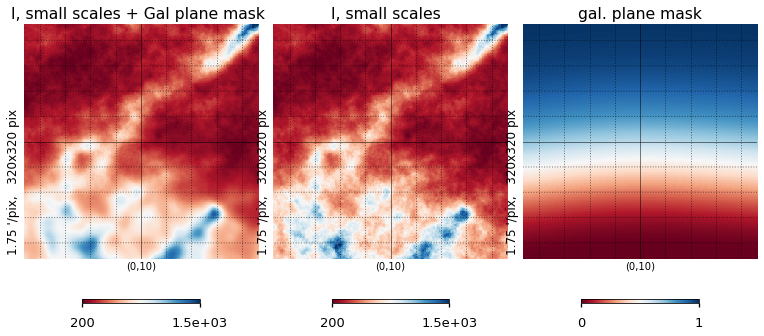

In [25]:
hp.gnomview( output_map2[0] 
           , 
           rot=[0,10],reso=1.75,xsize=320,title='I, small scales + Gal plane mask ',   
            cmap='RdBu', sub=131,min=200,max=1.5e3  
           ) 
hp.gnomview( output_map[0] 
           , 
           rot=[0,10],reso=1.75,xsize=320,title='I, small scales  ' ,  cmap='RdBu',
            sub=132,  min=200,max=1.5e3
           ) 

hp.gnomview(galplane_mask, title='gal. plane mask'  
           , 
           rot=[0,10],reso=1.75,xsize=320,  cmap='RdBu', sub=133, min=0,max=1
           ) 
hp.graticule(alpha=.5) 

83.44964889315526 96.55035110684474 -6.550351106844744 6.550351106844744
83.44964889315526 96.55035110684474 -6.550351106844744 6.550351106844744
83.44964889315526 96.55035110684474 -6.550351106844744 6.550351106844744


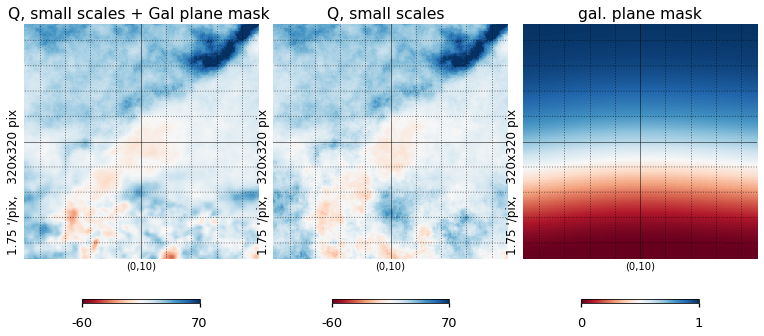

In [26]:
hp.gnomview( output_map2[1] 
           , 
           rot=[0,10],reso=1.75,xsize=320,title='Q, small scales + Gal plane mask ',   
            cmap='RdBu', sub=131,min=-60,max =70
           ) 
hp.gnomview( output_map[1] 
           , 
           rot=[0,10],reso=1.75,xsize=320,title='Q, small scales  ' ,  cmap='RdBu',
            sub=132, min=-60,max =70
           ) 

hp.gnomview(galplane_mask, title='gal. plane mask'  
           , 
           rot=[0,10],reso=1.75,xsize=320,  cmap='RdBu', sub=133, min=0,max=1
           ) 
hp.graticule(alpha=.5) 

83.44964889315526 96.55035110684474 -6.550351106844744 6.550351106844744
83.44964889315526 96.55035110684474 -6.550351106844744 6.550351106844744
83.44964889315526 96.55035110684474 -6.550351106844744 6.550351106844744


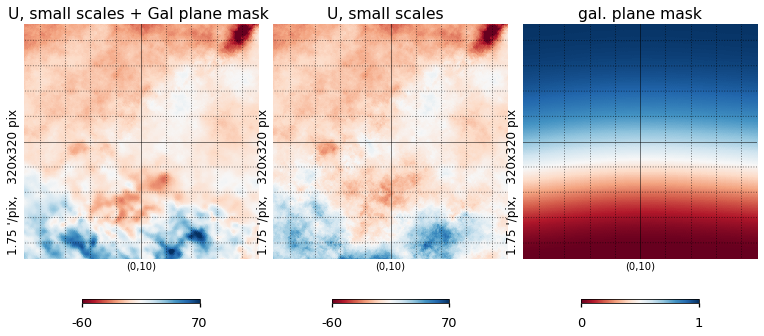

In [27]:
hp.gnomview( output_map2[2] 
           , 
           rot=[0,10],reso=1.75,xsize=320,title='U, small scales + Gal plane mask ',   
            cmap='RdBu', sub=131,min=-60,max =70
           ) 
hp.gnomview( output_map[2] 
           , 
           rot=[0,10],reso=1.75,xsize=320,title='U, small scales  ' ,  cmap='RdBu',
            sub=132, min=-60,max =70
           ) 

hp.gnomview(galplane_mask, title='gal. plane mask'  
           , 
           rot=[0,10],reso=1.75,xsize=320,  cmap='RdBu', sub=133, min=0,max=1
           ) 
hp.graticule(alpha=.5) 

## Compare spectra

In [28]:
ell, cl_norm, cli   = run_anafast(m_planck_varres, lmax=2048 )


In [29]:
ell, cl_norm, cl1  = run_anafast(output_map, lmax=2048 )
ell, cl_norm, cl2  = run_anafast(output_map2, lmax=2048 )

In [30]:
planck_masks ={ "GAL097": hp.read_map(planck_mask_filename, ["GAL097"]),
                "GAL099": hp.read_map(planck_mask_filename, ["GAL099"]),
                "GAL090": hp.read_map(planck_mask_filename, ["GAL090"])
              }


GAL097
GAL099
GAL090


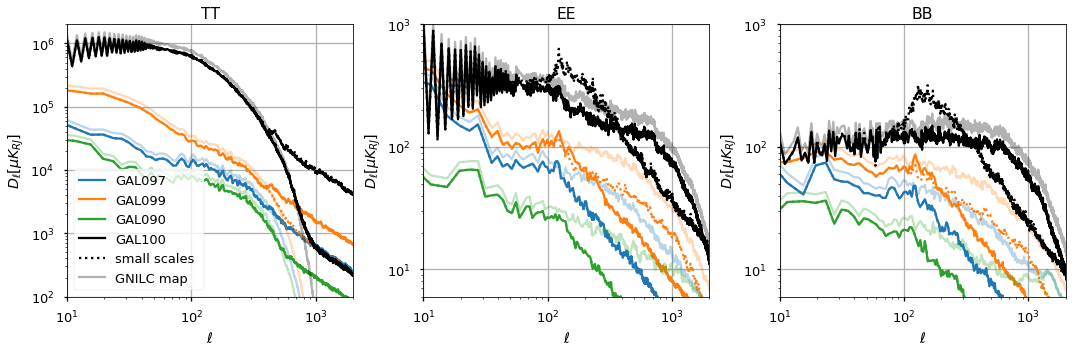

In [31]:
plt.figure(figsize=(15,5))

for jj, k in enumerate(planck_masks.keys())  :
#for jj, k in enumerate( ["GAL099"] )  :
    print(k) 
    fspectra = datadir / f"dust_gnilc_varres_no_monopole_gal{k[3:]}_spectra.npz"
    
    input_ell, _, cl_in = run_namaster(
            m_planck_varres, mask=planck_masks[k], lmax=lmax, nlbins = 4
        )    
    output_ell, _, cl_out = run_namaster(
            output_map, mask=planck_masks[k], lmax=lmax, nlbins = 4
        )    
    _, _, cl_out2 = run_namaster(
            output_map2, mask=planck_masks[k], lmax=lmax, nlbins = 4
        ) 
    del _
    for ii, pol in enumerate(["TT","EE", "BB" ]):
        plt.subplot(  1,3,ii+1 )
       
        plt.loglog(output_ell,  output_ell**2* (cl_out [pol])  ,
                   color='C%d'%jj,label =f"{k}")             
        plt.loglog(output_ell,  output_ell**2*  (cl_out2 [pol]) ,':',  color='C%d'%jj,  )             
        plt.loglog(input_ell,   input_ell**2*  (cl_in [pol]),'-',  color='C%d'%jj,alpha=.3,)

        plt.grid()
        plt.ylabel("$ D_\ell  [\mu K_{RJ}]$")
        plt.xlabel(("$\ell$"))
        plt.xlim(10,2e3) 
        
        if jj == 2 :
            plt.title(pol) 
            plt.loglog( ell,  ell**2 *(cl2 [pol]), color='k' , label =f"GAL100") 
            
            plt.loglog( ell,  ell**2 *(cl1 [pol]),":", label='small scales ' ,color='k' ,) 
            plt.loglog( ell,  ell**2 *(cli [pol]),'-',   label='GNILC map ',color='k' ,alpha=.3) 
        if pol=='TT': 
            plt.ylim(1e2,2e6)
            plt.legend()
        else :
            plt.ylim(6e0,1e3)
    #break   
    del cl_in, cl_out, cl_out2
plt.tight_layout() 